In [4]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline


# Initialize SparkSession
spark = SparkSession.builder \
    .appName("PoissonRegression") \
    .getOrCreate()

# Load your dataset into a Spark DataFrame
data = spark.read.csv("/storage/home/mdl5637/DS340/injuries.csv", header=True, inferSchema=True)

# Select relevant columns
selected_data = data.select(['surface', 'Avg_Temp', 'num_injuries'])

# Preprocess categorical variable 'surface'
string_indexer = StringIndexer(inputCol="surface", outputCol="surface_index")
encoder = OneHotEncoder(inputCol="surface_index", outputCol="surface_encoded")

# Define pipeline
pipeline = Pipeline(stages=[string_indexer, encoder])

# Fit pipeline
pipeline_model = pipeline.fit(selected_data)

# Apply pipeline to data
transformed_data = pipeline_model.transform(selected_data)

# Prepare data for modeling
assembler = VectorAssembler(inputCols=['surface_encoded', 'Avg_Temp'], outputCol="features")
prepared_data = assembler.transform(transformed_data).select("features", "num_injuries")

# Split data into training and testing sets
train_data, test_data = prepared_data.randomSplit([0.8, 0.2], seed=123)

# Define Poisson regression model
poisson_reg = GeneralizedLinearRegression(featuresCol='features', labelCol='num_injuries', 
                                          family="poisson", link="log")

# Train the model
poisson_model = poisson_reg.fit(train_data)

# Make predictions
predictions = poisson_model.transform(test_data)

# Evaluate model performance
evaluator = RegressionEvaluator(labelCol="num_injuries", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

# Stop SparkSession
spark.stop()


Root Mean Squared Error (RMSE) on test data = 1.84398


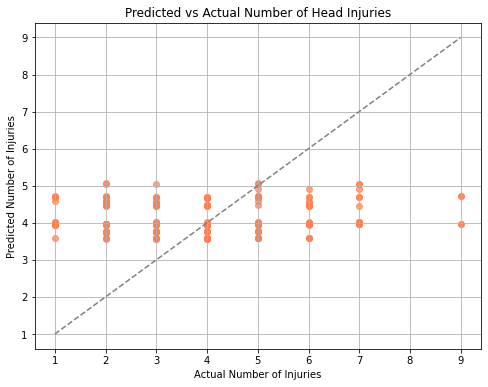

In [5]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import numpy as np

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("PoissonRegression") \
    .getOrCreate()

# Load your dataset into a Spark DataFrame
data = spark.read.csv("/storage/home/mdl5637/DS340/injuries.csv", header=True, inferSchema=True)

# Select relevant columns
selected_data = data.select(['surface', 'Avg_Temp', 'num_injuries'])

# Preprocess categorical variable 'surface'
string_indexer = StringIndexer(inputCol="surface", outputCol="surface_index")
encoder = OneHotEncoder(inputCol="surface_index", outputCol="surface_encoded")

# Define pipeline
pipeline = Pipeline(stages=[string_indexer, encoder])

# Fit pipeline
pipeline_model = pipeline.fit(selected_data)

# Apply pipeline to data
transformed_data = pipeline_model.transform(selected_data)

# Prepare data for modeling
assembler = VectorAssembler(inputCols=['surface_encoded', 'Avg_Temp'], outputCol="features")
prepared_data = assembler.transform(transformed_data).select("features", "num_injuries")

# Split data into training and testing sets
train_data, test_data = prepared_data.randomSplit([0.8, 0.2], seed=123)

# Define Poisson regression model
poisson_reg = GeneralizedLinearRegression(featuresCol='features', labelCol='num_injuries', 
                                          family="poisson", link="log")

# Train the model
poisson_model = poisson_reg.fit(train_data)

# Make predictions on the test data
predictions = poisson_model.transform(test_data)

# Convert predictions and actual values to Pandas DataFrame
predictions_df = predictions.select("prediction", "num_injuries").toPandas()

# Collect predicted and actual values
predicted_values = np.array(predictions_df["prediction"])
actual_values = np.array(predictions_df["num_injuries"])

# Plot predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predicted_values, color='coral', alpha=0.7)
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], linestyle='--', color='gray')
plt.title('Predicted vs Actual Number of Head Injuries')
plt.xlabel('Actual Number of Injuries')
plt.ylabel('Predicted Number of Injuries')
plt.grid(True)
plt.show()

# Stop SparkSession
spark.stop()


In [8]:
# Calculate correlation coefficient
correlation_coefficient = np.corrcoef(actual_values, predicted_values)[0, 1]
print("Correlation Coefficient between Predicted and Actual Number of Head Injuries:", correlation_coefficient)


Correlation Coefficient between Predicted and Actual Number of Head Injuries: 0.08840365248652507


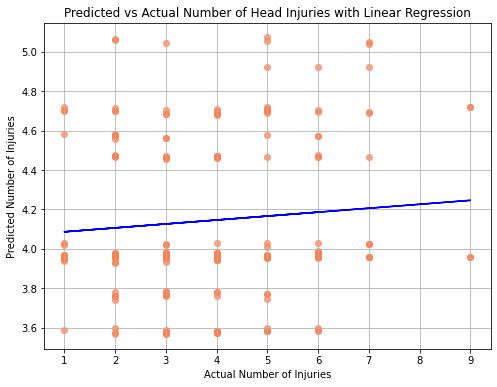

Regression Coefficients: 0.019949388267281126
Intercept: 4.06614957913827


In [10]:
from sklearn.linear_model import LinearRegression

X = actual_values.reshape(-1, 1)  # Actual values
y = predicted_values.reshape(-1, 1)  # Predicted values

regressor = LinearRegression()
regressor.fit(X, y)

y_pred = regressor.predict(X)

plt.figure(figsize=(8, 6))
plt.scatter(X, y, color='coral', alpha=0.7)
plt.plot(X, y_pred, color='blue')
plt.title('Predicted vs Actual Number of Head Injuries with Linear Regression')
plt.xlabel('Actual Number of Injuries')
plt.ylabel('Predicted Number of Injuries')
plt.grid(True)
plt.show()

regression_coef = regressor.coef_[0][0]
intercept = regressor.intercept_[0]
print("Regression Coefficients:", regression_coef)
print("Intercept:", intercept)
